![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 029</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">使用データ:toxic-span</li>
    <li style = "color:#4c1c84;
                font-size:14px">使用モデル:RoBERTa-Base</li>
    <li style = "color:#4c1c84;
                font-size:14px">Attentionの可視化</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")

In [2]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

2022-01-26 10:12:32.965872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
import torch

config = {
    "exp_comment":"toxic-spanをRoBERTaで学習",
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "029_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "roberta-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.BCEWithLogitsLoss",
}

config = Box(config)
config.tokenizer = RobertaTokenizer.from_pretrained(config.backbone.name)
config.model = RobertaModel.from_pretrained(config.backbone.name)
# pprint(config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
config.tokenizer.save_pretrained(f"../data/processed/{config.backbone.name}")

pretrain_model = RobertaModel.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(f"../data/processed/{config.backbone.name}")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/029_exp
OUTPUT_DIR is ../data/interim/029_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [8]:
# Seed固定
seed_everything(config.seed)

42

In [9]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [10]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [11]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Toxic-Span
</h2>
<br>

In [17]:
comment_df = pd.read_csv("../data/external/toxic_spans/data/comments.csv")
anno_df = pd.read_csv("../data/external/toxic_spans/data/annotations.csv")

display(comment_df.head())
display(anno_df.head())

,comment_id,comment_text
0,239607,Yet call out all Muslims for the acts of a few...
1,239612,This bitch is nuts. Who would read a book by a...
2,240311,You're an idiot.
3,240400,"Nincompoop, that's a nice one! I'm partial to ..."
4,240461,testing purposes: \n\nyou are an idiot and i c...


,annotation,comment_id,worker,country,all toxic,not toxic
0,0,5167187,868,USA,False,False
1,1,5167187,1316,USA,False,False
2,2,5167187,1295,USA,False,True
3,3,5167187,2856,USA,False,False
4,4,5521110,418,VEN,True,True


In [18]:
anno_df["all_toxic"] = anno_df["all toxic"].astype("int")
anno_df["not_toxic"] = anno_df["not toxic"].astype("int")
display(anno_df.head())

,annotation,comment_id,worker,country,all toxic,not toxic,all_toxic,not_toxic
0,0,5167187,868,USA,False,False,0,0
1,1,5167187,1316,USA,False,False,0,0
2,2,5167187,1295,USA,False,True,0,1
3,3,5167187,2856,USA,False,False,0,0
4,4,5521110,418,VEN,True,True,1,1


In [19]:
anno_df_v2 = anno_df.groupby("comment_id")["all_toxic", "not_toxic"].agg("mean")
display(anno_df_v2.head())


train_df = pd.merge(
    comment_df,
    anno_df_v2,
    on="comment_id",
    how="left"
)

display(train_df.head())

,all_toxic,not_toxic
comment_id,,
239607,0.333333,0.333333
239612,0.333333,0.666667
240311,0.000000,0.000000
240400,0.000000,0.000000
240461,0.000000,0.000000


,comment_id,comment_text,all_toxic,not_toxic
0,239607,Yet call out all Muslims for the acts of a few...,0.333333,0.333333
1,239612,This bitch is nuts. Who would read a book by a...,0.333333,0.666667
2,240311,You're an idiot.,0.000000,0.000000
3,240400,"Nincompoop, that's a nice one! I'm partial to ...",0.000000,0.000000
4,240461,testing purposes: \n\nyou are an idiot and i c...,0.000000,0.000000


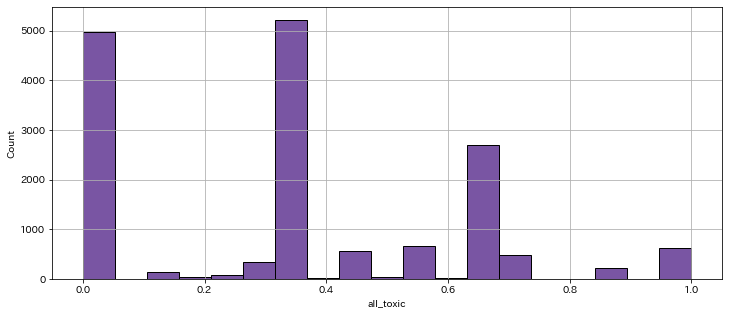

In [20]:
target_cols = [
    "all_toxic"
]

plt.figure(figsize=(12, 5))
sns.histplot(train_df["all_toxic"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Pytorch Dataset
</h1>
<br>

In [22]:
class JigsawDataset:
    
    def __init__(self, df, tokenizer, max_length, mode, target_cols):
        
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        self.target_cols = target_cols
        
        if self.mode == "train":
            self.text = df["comment_text"].values
            self.target = df[target_cols].values
            
        elif self.mode == "valid":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            text = self.text[index]
            target = self.target[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        else:
            
            text = self.text[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    DataModule
</h2>
<br>

In [23]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="train",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="valid",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="test",
            target_cols=target_cols
        )

        return DataLoader(dataset, **self._cfg.test_loader)

In [24]:
## DataCheck
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(train_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [25]:
print(data["text_ids"].size())
print(data["text_mask"].size())
print(data["text_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
output = config.model(
    data["text_ids"],
    data["text_mask"],
    data["text_token_type_ids"],
    output_attentions=True
)
print(output["last_hidden_state"].size(), output["attentions"][-1].size())
print(output["last_hidden_state"][:, 0, :].size(), output["attentions"][-1].size())

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 1])
tensor([[0.6667],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.3333],
        [0.3333],
        [0.7143],
        [0.4286]])
torch.Size([8, 256, 768]) torch.Size([8, 12, 256, 256])
torch.Size([8, 768]) torch.Size([8, 12, 256, 256])


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    LigitningModule
</h2>
<br>

In [26]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = RobertaModel.from_pretrained(
            self.cfg.backbone.name
        )
        print(f"Use Model: {self.cfg.backbone.name}")
        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)
        
    def forward(self, ids, mask, token_type_ids):
        
        output = self.base_model(
            input_ids=ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_attentions=True
        )
        feature = self.norm(output["last_hidden_state"][:, 0, :])
        out = self.drop(feature)
        out = self.head(out)
        
        return {
            "logits":out, 
            "attention":output["attentions"], 
            "mask":mask,
        }
    
    def training_step(self, batch, batch_idx):
        
        text_ids = batch["text_ids"]
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        loss = self.criterion(outputs["logits"], targets)
        
        return {
            "loss":loss,
            "targets":targets,
        }
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']

        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        
        more_outputs = torch.sum(more_outputs["logits"], 1)
        less_outputs = torch.sum(less_outputs["logits"], 1)
        
        outputs = more_outputs - less_outputs
        logits = outputs.clone()

        logits[logits > 0] = 1
        loss = self.criterion(logits, targets)

        return {
            "loss":loss,
            "pred":outputs,
            "targets":targets,
        }
    
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].detach().cpu().numpy())
            target_list.append(out["targets"].detach().cpu().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        pred_count = sum(x>0 for x in pred_list)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":pred_count,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Training
</h2>
<br>

In [28]:
labels, uniques = pd.factorize(train_df["all_toxic"], sort=True)
train_df["label"] = labels

In [29]:

skf = StratifiedKFold(
    n_splits=config.n_fold, 
    shuffle=True, 
    random_state=config.seed
)

for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df["label"])):
    train_df.loc[val_idx, "kfold"] = int(fold)

train_df["kfold"] = train_df["kfold"].astype(int)
train_df.head()

,comment_id,comment_text,all_toxic,not_toxic,label,kfold
0,239607,Yet call out all Muslims for the acts of a few...,0.333333,0.333333,6,2
1,239612,This bitch is nuts. Who would read a book by a...,0.333333,0.666667,6,0
2,240311,You're an idiot.,0.000000,0.000000,0,3
3,240400,"Nincompoop, that's a nice one! I'm partial to ...",0.000000,0.000000,0,1
4,240461,testing purposes: \n\nyou are an idiot and i c...,0.000000,0.000000,0,4


In [30]:
## Debug
config.trainer.fast_dev_run = True
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "toxic-spans"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.59it/s loss: 0.656 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.45it/s loss: 0.725 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.37it/s loss: 0.925 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.25it/s loss: 0.736 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.22it/s loss: 0.699 v_num:  

In [31]:
## Training
config.trainer.fast_dev_run = False
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "toxic-spans"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-26 10:32:53.436189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to se

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 5374/5374 0:08:12 • 0:00:00 12.67it/s loss: 0.628 v_num:    
                                                                       10hx valid_loss/fold1:
                                                                       0.647 valid_acc/fold1:
                                                                       0.381                 
                                                                       train_loss/fold1:     
                                                                       0.079                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 5374/5374 0:08:11 • 0:00:00 12.72it/s loss: 0.629 v_num:    
                                                                       10hx valid_loss/fold2:
                                                                       0.668 valid_acc/fold2:
                                                                       0.376                 
                                                                       train_loss/fold2:     
                                                                       0.082                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 5374/5374 0:08:12 • 0:00:00 12.68it/s loss: 0.612 v_num:    
                                                                       10hx valid_loss/fold3:
                                                                       0.649 valid_acc/fold3:
                                                                       0.396                 
                                                                       train_loss/fold3:     
                                                                       0.081                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel      │  124 M │
│ 1 │ norm       │ LayerNorm         │  1.5 K │
│ 2 │ drop       │ Dropout           │      0 │
│ 3 │ head       │ Linear            │    769 │
│ 4 │ criterion  │ BCEWithLogitsLoss │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 498

Output()

Epoch 3    ━━━━━━━━━━━━╸━━━━━━━━ 3252/5374 0:05:25 • 0:02:46 12.82it/s loss: 0.677 v_num:    
                                                                       10hx valid_loss/fold4:
                                                                       0.611 valid_acc/fold4:
                                                                       0.418                 
                                                                       train_loss/fold4:     
                                                                       0.085                 
Validation ━━━━━━━━━╺━━━━━━━━━━━ 1642/3764 0:02:08 • 0:02:46 12.82it/s loss: 0.677 v_num:    
                                                                       10hx valid_loss/fold4:
                                                                       0.611 valid_acc/fold4:
                                                                       0.418                 
                                                                       train_loss/fold4:     
                                                                       0.085                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★


KeyboardInterrupt: 

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

MORE = np.zeros((len(val_df), config.backbone.output_dim))
LESS = np.zeros((len(val_df), config.backbone.output_dim))
PRED = np.zeros((len(test_df), config.backbone.output_dim))

attention_array = np.zeros((len(val_df), 256)) # attention格納
mask_array = np.zeros((len(val_df), 256)) # mask情報格納,後でattentionと掛け合わせる

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    valid_dataloader = JigsawDataModule(train_df, val_df, test_df, config).val_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    more_list = []
    less_list = []
    
    for step, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):

        more_toxic_ids = data['more_toxic_ids'].to(device)
        more_toxic_mask = data['more_toxic_mask'].to(device)
        more_text_token_type_ids = data['more_token_type_ids'].to(device)
        
        less_toxic_ids = data['less_toxic_ids'].to(device)
        less_toxic_mask = data['less_toxic_mask'].to(device)
        less_text_token_type_ids = data['less_token_type_ids'].to(device)
        
        more_outputs = model(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids,
        )
        
        less_outputs = model(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        more_list.append(more_outputs["logits"].detach().cpu().numpy())
        less_list.append(less_outputs["logits"].detach().cpu().numpy())

    MORE += np.concatenate(more_list)/len(config.train_fold)
    LESS += np.concatenate(less_list)/len(config.train_fold)
#     PRED += pred_list/len(config.train_fold)

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Model: roberta-base


  0%|          | 0/3764 [00:00<?, ?it/s]

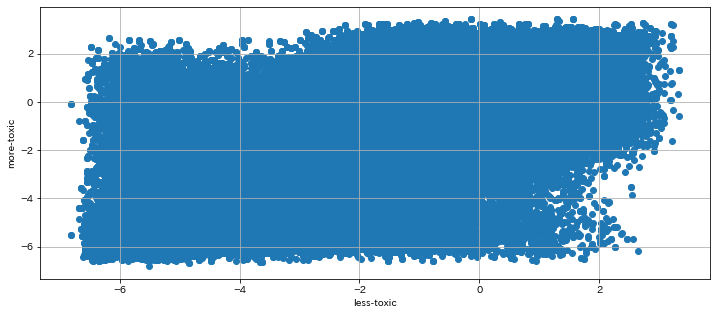

In [21]:
plt.figure(figsize=(12, 5))
plt.scatter(LESS, MORE)
plt.xlabel("less-toxic")
plt.ylabel("more-toxic")
plt.grid()
plt.show()

In [23]:
val_df["less_attack"] = LESS.sum(axis=1)
val_df["more_attack"] = MORE.sum(axis=1)
val_df["diff_attack"] = val_df["more_attack"] - val_df["less_attack"]
attack_score = val_df[val_df["diff_attack"]>0]["diff_attack"].count()/len(val_df)
print(f"Wiki Attack Score: {attack_score:.6f}")

Wiki Attack Score: 0.697124
